<a href="https://colab.research.google.com/github/NonRelDat/P2019_T6/blob/main/P2019_T6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



INL, zadanie 2

POLEVAL 2019, zadanie 6
Automatic cyberbullying detection

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [15]:
#instalacja Spacy

!python -m pip install spacy==2.3.2 -q
!python -m spacy download pl_core_news_md
!python -m spacy download pl_core_news_lg


     |████████████████████████████████| 79.9 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_md')
     |████████████████████████████████| 604.2 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_lg')


In [20]:
#import bibliotek
import pandas as pd
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
import spacy
import re
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

Wczytywanie danych

In [5]:
#dane treningowe
dane_treningowe1 = '/content/drive/MyDrive/training_set_clean_only_tags.txt'
dane_treningowe2 = '/content/drive/MyDrive/training_set_clean_only_text.txt'

df1 = pd.read_csv(dane_treningowe1, delimiter = "\t", header = None)
df1.columns = ['tag']

df2 = pd.read_csv(dane_treningowe2, delimiter = "\t", header = None)
df2.columns = ['tweets_txt']

training_data = pd.concat([df1.reset_index(drop = True), df2], axis = 1)
training_data.head(10)

,tag,tweets_txt
0,0,Dla mnie faworytem do tytułu będzie Cracovia. ...
1,0,@anonymized_account @anonymized_account Brawo ...
2,0,"@anonymized_account @anonymized_account Super,..."
3,0,@anonymized_account @anonymized_account Musi. ...
4,0,"Odrzut natychmiastowy, kwaśna mina, mam problem"
5,0,"Jaki on był fajny xdd pamiętam, że spóźniłam s..."
6,0,@anonymized_account No nie ma u nas szczęścia 😉
7,0,@anonymized_account Dawno kogoś tak wrednego n...
8,0,@anonymized_account @anonymized_account Zaległ...
9,1,@anonymized_account @anonymized_account @anony...


In [6]:
#dane testowe
dane_testowe1 = '/content/drive/MyDrive/test_set_clean_only_tag.txt'
dane_testowe2 = '/content/drive/MyDrive/test_set_clean_only_tex.txt'

df3 = pd.read_csv(dane_testowe1, delimiter = "\t", header = None)
df3.columns = ['tag']
df4 = pd.read_csv(dane_testowe2, delimiter = "\t", header = None)
df4.columns = ['tweets_txt']

test_data = pd.concat([df3.reset_index(drop = True), df4], axis = 1)
test_data.head(10)

,tag,tweets_txt
0,0,"@anonymized_account Spoko, jak im Duda z Moraw..."
1,0,@anonymized_account @anonymized_account Ale on...
2,0,@anonymized_account No czy Prezes nie miał rac...
3,0,@anonymized_account @anonymized_account Przeci...
4,0,@anonymized_account @anonymized_account Owszem...
5,0,@anonymized_account @anonymized_account skąd w...
6,0,"Z tego, co widzę, to kibice Widzewa mają szczę..."
7,0,@anonymized_account @anonymized_account @anony...
8,0,Przypomnijcie mi ze muszę jeszcze suszarkę spa...
9,0,"Czy Adam już nie żyje? Jeśli tak, to jak rozwi..."


In [7]:
#oznaczanie tagów
tags = {0: 'Neutral', 1: 'Harmful'}
test_data["tag_val"] = test_data["tag"].map(tags)
training_data["tag_val"] = training_data["tag"].map(tags)

df = training_data.append(test_data, ignore_index = True)

Pre-processing danych

In [8]:
#usuwanie duplikatów
df['tweets_txt'].drop_duplicates(keep = 'first', inplace = True)

#przetwarzanie tekstu na małe litery
df['tweets_txt'] = df['tweets_txt'].str.lower()
df.head()



,tag,tweets_txt,tag_val
0,0,dla mnie faworytem do tytułu będzie cracovia. ...,Neutral
1,0,@anonymized_account @anonymized_account brawo ...,Neutral
2,0,"@anonymized_account @anonymized_account super,...",Neutral
3,0,@anonymized_account @anonymized_account musi. ...,Neutral
4,0,"odrzut natychmiastowy, kwaśna mina, mam problem",Neutral


In [9]:
#stopwords
import spacy.cli 
spacy.cli.download("pl_core_news_md")
nlp = spacy.load('pl_core_news_md')
lemma = WordNetLemmatizer()
nltk.download('wordnet')
stopwords = nlp.Defaults.stop_words
print(stopwords)

✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_md')
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
{'vii', 'wielu', 'jakichś', 'jakichs', 'miedzy', 'twoi', 'do', 'zeby', 'jakie', 'xiv', 'także', 'żadne', 'xi', 'owszem', 'jednym', 'wasza', 'ktory', 'dwaj', 'po', 'ani', 'dokąd', 'ją', 'beda', 'wasi', 'tu', 'niż', 'gdzie', 'wszystkie', 'około', 'toteż', 'był', 'nia', 'mi', 'mam', 'przede', 'wy', 'oraz', 'inna', 'gdy', 'chce', 'tej', 'przeciez', 'jak', 'jesli', 'sposob', 'mozna', 'caly', 'jakiż', 'tobie', 'byc', 'pana', 'mimo', 'było', 'wami', 'jednakże', 'powinna', 'nad', 'ciebie', 'zadnych', 'czy', 'prawie', 'zawsze', 'takze', 'nich', 'ja', 'ich', 'daleko', 'ten', 'nasza', 'gdziekolwiek', 'byli', 'go', 'którym', 'moze', 'cała', 'mają', 'dzisiaj', 'albo', 'taki', 'te', 'iż', 'trzeba', 'nasze', 'czasem', 'bez', 'znow', 'iv', 'dobrze', 'nasz', 'vi', 'tę', 'u', 'oto', 'mu', 'w', 'które

In [12]:
def cleaning_text(text):
  text = text.replace("@anonymized_account", ' ')
  text = text.replace("rt", ' ')
  text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text) 
  text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
  text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
  text = re.sub('[0-9]+', '', text)
  text = re.sub(r'(.)1+', r'1', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'_', '', text)
  text = re.sub('\t', '', text)
  text = ' '.join([w for w in text.split() if len(w)>1])
  text = ' '.join([lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(text) if x not in stopwords])
  text = [lemma.lemmatize(x, nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(text) if x not in stopwords]
  return text

In [17]:
df["clean_tokenized"] = df["tweets_txt"].apply(cleaning_text)
df["cleaned_text"] = df["clean_tokenized"].apply(lambda x:' '.join(x))
df.head()

,tag,tweets_txt,tag_val,clean_tokenized,cleaned_text
0,0,dla mnie faworytem do tytułu będzie cracovia. ...,Neutral,"[faworytem, tytułu, cracovia, zobaczymy, typ, ...",faworytem tytułu cracovia zobaczymy typ sprawdzi
1,0,@anonymized_account @anonymized_account brawo ...,Neutral,"[brawo, daria, kibic, dobre, złe]",brawo daria kibic dobre złe
2,0,"@anonymized_account @anonymized_account super,...",Neutral,"[super, polski, premier, składa, kwiaty, groba...",super polski premier składa kwiaty grobach kol...
3,0,@anonymized_account @anonymized_account musi. ...,Neutral,"[innej, drogi]",innej drogi
4,0,"odrzut natychmiastowy, kwaśna mina, mam problem",Neutral,"[odrzut, natychmiastowy, kwaśna, mina, problem]",odrzut natychmiastowy kwaśna mina problem


In [19]:
nlp = spacy.load('pl_core_news_lg')
tweets = df["cleaned_text"].to_string()
df["lemmatized"] = df["cleaned_text"].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))
df.head()

,tag,tweets_txt,tag_val,clean_tokenized,cleaned_text,lemmatized
0,0,dla mnie faworytem do tytułu będzie cracovia. ...,Neutral,"[faworytem, tytułu, cracovia, zobaczymy, typ, ...",faworytem tytułu cracovia zobaczymy typ sprawdzi,faworyt tytuł cracovia zobaczyć typ sprawdzić
1,0,@anonymized_account @anonymized_account brawo ...,Neutral,"[brawo, daria, kibic, dobre, złe]",brawo daria kibic dobre złe,brawo daria kibic dobry zły
2,0,"@anonymized_account @anonymized_account super,...",Neutral,"[super, polski, premier, składa, kwiaty, groba...",super polski premier składa kwiaty grobach kol...,super polski premiera składać kwiat grób kolab...
3,0,@anonymized_account @anonymized_account musi. ...,Neutral,"[innej, drogi]",innej drogi,inny droga
4,0,"odrzut natychmiastowy, kwaśna mina, mam problem",Neutral,"[odrzut, natychmiastowy, kwaśna, mina, problem]",odrzut natychmiastowy kwaśna mina problem,odrzut natychmiastowy kwaśny mina problem


Found 64686 words.


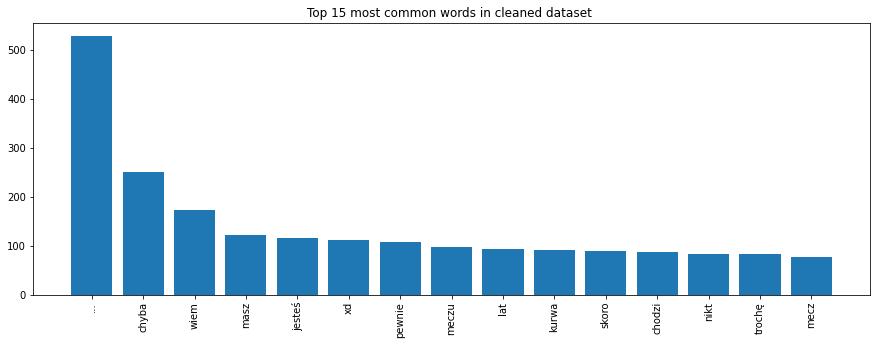

In [23]:
def get_most_common(txt, top = 20):
  words = (txt).split()
  print(f'Found {len(words)} words.')
  most_common = Counter(words).most_common(top)
  labels = []
  values = []
  for label, val in most_common:
    labels.append(label)
    values.append(val)
  return values, labels

def plot_most_common(txt_comments, top = 20, title = ''):
  values, labels = get_most_common(txt_comments, top)
  x = range(len(values))

  plt.figure(figsize = (15, 5))
  plt.bar(x, values)
  plt.xticks(x, labels, rotation = 90)
  plt.title(title)
  plt.show()

tweets = df['cleaned_text'].to_string()
plot_most_common(tweets, top = 15, title = 'Top 15 most common words in cleaned dataset ')

In [25]:
training_data_preprocessed = training_data.merge(df, how = 'right', on = ['tweets_txt', 'tag'])
training_data_preprocessed.head()

,tag,tweets_txt,tag_val_x,tag_val_y,clean_tokenized,cleaned_text,lemmatized
0,0,dla mnie faworytem do tytułu będzie cracovia. ...,NaN,Neutral,"[faworytem, tytułu, cracovia, zobaczymy, typ, ...",faworytem tytułu cracovia zobaczymy typ sprawdzi,faworyt tytuł cracovia zobaczyć typ sprawdzić
1,0,@anonymized_account @anonymized_account brawo ...,NaN,Neutral,"[brawo, daria, kibic, dobre, złe]",brawo daria kibic dobre złe,brawo daria kibic dobry zły
2,0,"@anonymized_account @anonymized_account super,...",NaN,Neutral,"[super, polski, premier, składa, kwiaty, groba...",super polski premier składa kwiaty grobach kol...,super polski premiera składać kwiat grób kolab...
3,0,@anonymized_account @anonymized_account musi. ...,NaN,Neutral,"[innej, drogi]",innej drogi,inny droga
4,0,"odrzut natychmiastowy, kwaśna mina, mam problem",NaN,Neutral,"[odrzut, natychmiastowy, kwaśna, mina, problem]",odrzut natychmiastowy kwaśna mina problem,odrzut natychmiastowy kwaśny mina problem


In [26]:
test_data_preprocessed = test_data.merge(df, how = 'right', on = ['tweets_txt', 'tag'])
test_data_preprocessed.head()

,tag,tweets_txt,tag_val_x,tag_val_y,clean_tokenized,cleaned_text,lemmatized
0,0,dla mnie faworytem do tytułu będzie cracovia. ...,NaN,Neutral,"[faworytem, tytułu, cracovia, zobaczymy, typ, ...",faworytem tytułu cracovia zobaczymy typ sprawdzi,faworyt tytuł cracovia zobaczyć typ sprawdzić
1,0,@anonymized_account @anonymized_account brawo ...,NaN,Neutral,"[brawo, daria, kibic, dobre, złe]",brawo daria kibic dobre złe,brawo daria kibic dobry zły
2,0,"@anonymized_account @anonymized_account super,...",NaN,Neutral,"[super, polski, premier, składa, kwiaty, groba...",super polski premier składa kwiaty grobach kol...,super polski premiera składać kwiat grób kolab...
3,0,@anonymized_account @anonymized_account musi. ...,NaN,Neutral,"[innej, drogi]",innej drogi,inny droga
4,0,"odrzut natychmiastowy, kwaśna mina, mam problem",NaN,Neutral,"[odrzut, natychmiastowy, kwaśna, mina, problem]",odrzut natychmiastowy kwaśna mina problem,odrzut natychmiastowy kwaśny mina problem


Budowanie i ewaluacja modelu

In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np



In [34]:
X_train = training_data_preprocessed['lemmatized'].astype('U')
Y_train = training_data_preprocessed['tag'].astype('U')

X_test = training_data_preprocessed['lemmatized'].astype('U')
Y_test = training_data_preprocessed['tag'].astype('U')

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10041)
vectors = vectorizer.fit_transform(X_train, X_test)
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Ewaluacja modelu

In [47]:
def Evaluate(model):
  Y_pred = model.predict(X_test_vec)

  print(classification_report(Y_test, Y_pred))

  cf_matrix = confusion_matrix(Y_test, Y_pred)
  categories = ['Negative', 'Positive']
  group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
  labels = np.asarray(labels).reshape(2, 2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Greens', fmt = '', xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Acutal values", fontdict = {'size':18}, labelpad = 20)


Linear support vector

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10056
           1       0.98      0.78      0.87       985

    accuracy                           0.98     11041
   macro avg       0.98      0.89      0.93     11041
weighted avg       0.98      0.98      0.98     11041



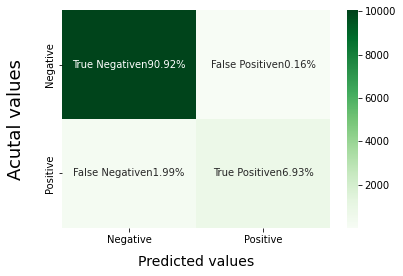

In [51]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train_vec, Y_train)
Evaluate(SVCmodel)
Y_pred_LSV = SVCmodel.predict(X_test_vec)

Regresja logistyczna

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10056
           1       0.93      0.06      0.12       985

    accuracy                           0.92     11041
   macro avg       0.92      0.53      0.54     11041
weighted avg       0.92      0.92      0.88     11041



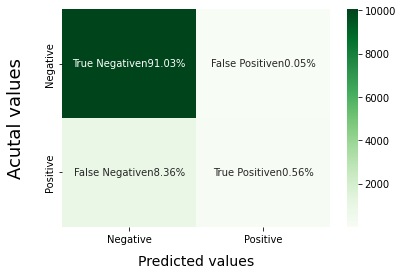

In [52]:
LRmodel = LogisticRegression(max_iter = 1000)
Y_pred_LR = LRmodel.fit(X_train_vec, Y_train).decision_function(X_test_vec)
Evaluate(LRmodel)